<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20Di%20Testi/05_Text_Generation.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Generation





Sentence Embedding measures how close are different sentences. Sentence simularity is useful for information retrieval, clustering or grouping.
Sentence Embedding convert input text into vectors, which are called embeddings. This embeddings caputure semantic information, so that the similarity between two sentences becomes the similarity between two vectors





#### 1 - Install dependencies and create utils functions

Firstly, we make sure to install all the needed libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

Suppress warning messages

In [2]:
from transformers.utils import logging
logging.set_verbosity_error()

#### 2 - Build and use a Text Generation Model

At this point, we load the Gtp 2 model from Huggingface. We use GPT 2 because is a small model and it is faster to run than other models.
GPT 2 is a decoder only model, is doesn't have an encoder. We directly pass the input to an embedding and then we apply repea series of blocks, specifically an At

In [4]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

Create the input and pass it to the tokenizer. We will create an input object composed by two tensors: one is the input_ids tensor, which are the mapping of particular chunks of the text, and the attention mask, which is at the moment a series of 1 with the same lenght of the input_ids tensor

In [22]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

Then, we pass the inputs to the model

In [23]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape) # 1 is the batch size, 7 is the sequence lenght, and 50257 is the vocabulary size (how many possibile tokens we might generate from the output)

torch.Size([1, 7, 50257])


Then, we determine which of those 50257 we want to use. To do that, we take the first row of the logit tensor (which is the only one given the batch size of 1), and then specifically take all the elements of the last sequence and of that subset we take the index which has the maximum value

In [24]:
last_logits = logits[0, -1, :]
print(last_logits)
next_token_id = last_logits.argmax()
next_token_id

tensor([-92.9353, -92.3160, -96.0634,  ..., -95.3960, -96.1433, -94.6932])


tensor(13990)

Use the tokenizer to decode the string

In [25]:
tokenizer.decode(next_token_id)

' fence'

Instead of the top 1 we could look at the top 10 of the most likely tokens

In [26]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

Concatenate the input and most likely tokens

In [13]:
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}

print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]) torch.Size([1, 8])
tensor([[1, 1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 8])


In [27]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [32]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]

    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

0.7180473804473877 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


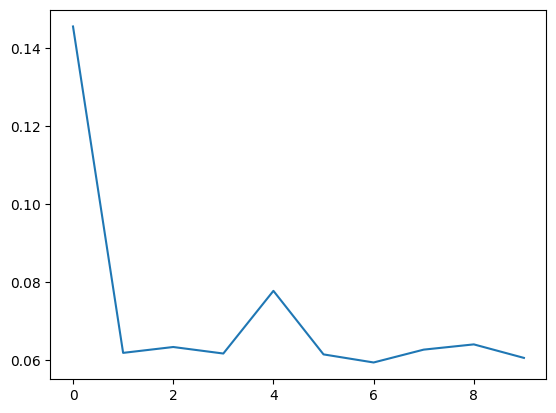

In [33]:

plt.plot(durations_cached_s)
plt.show()